## Домашняя работа 3. Катя Гриневская, БКЛ182

Сначала импортирую всё необходимое

In [7]:
!pip install nltk

In [100]:
from collections import Counter

In [227]:
import operator

In [106]:
from operator import itemgetter


In [8]:
!pip install spacy

In [9]:
!pip  install pyLDAvis

     |████████████████████████████████| 1.6MB 2.8MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=d92600f357d797cb6bd9ad8faca78262d9a99e9d02e0fec4c52b6e4870f5b27f
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [2]:
import nltk; nltk.download('stopwords')


!python3 -m spacy download en

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [10]:
spacy.load('en')

In [11]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

Здесь делаю как в семинаре

In [12]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [13]:
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [14]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [15]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [16]:
bigrams = [b for l in data for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]
freq = nltk.FreqDist(bigrams) #computes freq of occurrence
fdist = freq.keys() # sorted according to freq

Mallet у меня не сработал, так что делала gensim-ом.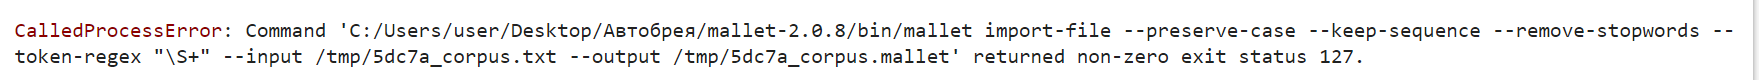

In [17]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [18]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [19]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 'thing', 'car', 'nntp_poste', 'host', 'park', 'line', 'wonder', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


In [20]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 5), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)]]


In [21]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('body', 1),
  ('bricklin', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_poste', 1),
  ('park', 1),
  ('production', 1),
  ('really', 1),
  ('rest', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('sport', 1),
  ('tellme', 1),
  ('thank', 1),
  ('thing', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

Здесь функция для выбора оптимального числа топиков: у меня получилось 19

In [30]:
def best_num(start, limit, step):
  num_dict = {}
  for n in range(start, limit, step):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    num_dict[n] = coherence_lda
    print(n, ' ', coherence_lda)
  best_num = max(num_dict,key=num_dict.get)
  return best_num

In [31]:
best_num = best_num(4, 26, 5) # на всякий случай вывожу, чтобы видеть, что всё норм работает

4   0.38945426450083365
9   0.4514692455752538
14   0.4581179066989397
19   0.4722627871932223
24   0.45049782434951174


Теперь запускаю для оптимального числа топиков

In [33]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=best_num, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

Здесь создаю словарь типа {номер_топика : 10 слов с весами}

In [50]:
idtopic_words = {}
for idx, topic in lda_model.show_topics(formatted=False, num_words= 10):
  d = {}
  for w in topic:
   d[w[0]] = w[1]
  idtopic_words[idx] = d

Теперь функция, где получаю словарь {текст_ввидестроки : номер_главного_топика}. Я знаю, что лучше было бы поменять местами ключ и значение, тогда бы не пришлось список лемматизированных слов каждого текста превращать в строку, но на момент решения мне казалось это гениальной идеей, а потом пришлось возвращать эти слепленные строки в номральные списки :(

In [73]:
def getting_main_topic(idtopic_words):
  c_topics = {}
  c_texts = {}
  for text in texts:
    for idx in idtopic_words.keys():
      c_topics[idx] = 0
    c_texts[str(text)] = 0
    for word in text:
      for idx, value in idtopic_words.items():
        if word in value.keys():
          c_topics[idx] += value[word]
    c_texts[str(text)] = max(c_topics, key=c_topics.get)
  return c_texts

In [74]:
c_texts = getting_main_topic(idtopic_words)

Теперь группирую тексты по главному топику

In [78]:
def group_texts(c_texts):
  topic_text = {}
  for key, value in c_texts.items():
    topic_text[value] = []
  for key, value in c_texts.items():
    topic_text[value].append(key)
  return topic_text

In [146]:
topic_text = group_texts(c_texts)

Вот тут как раз возвращаю тексты к нормальному виду и получаю словарь типа {номер_топика: список_текстов}

In [144]:
def normal_text(topic_text):
  topic_text_norm = {}
  for key, value in topic_text.items():
    list_text = []
    for t in value:
      new_t = []
      t = t.split()
      for a in t:
        a = a.replace("'", '').replace("[", '').replace("]", '').replace(',', '')
        new_t.append(a)
      list_text.append(new_t)
    topic_text_norm[key] = list_text
  return topic_text_norm

In [147]:
topic_text_norm = normal_text(topic_text)

Теперь создаю датафрейм уже для необходимой выдачи

In [174]:
dataframe = pd.DataFrame()
dataframe['lemmatized_text'] = data_lemmatized
all_topics = []
for text in dataframe['lemmatized_text']:
  for key, value in topic_text_norm.items():
    if text in value:
      all_topics.append(key)
dataframe['main_topic'] = all_topics

Здесь считаю TF и функция мне выдаёт словарь {слово: TF}

In [180]:
def computeTF(wordDict, bagofwords):
  tfDict = {}
  bagOfWordsCount = len(bagofwords)
  for word, count in wordDict.items():
      tfDict[word] = count / float(bagOfWordsCount)
  return tfDict

Чтобы мне проще было занести эту информацию в датафрейм, я создаю список, в котором у меня последовательно расположены словарики с TF-ами для каждого текста

In [182]:
list_tfDict = []
for text in dataframe['lemmatized_text']:
  uniqwords = set(text)
  numOfWords = dict.fromkeys(uniqwords, 0)
  for word in text:
    numOfWords[word] += 1
  list_tfDict.append(computeTF(numOfWords, text))

In [223]:
dataframe['TF'] = list_tfDict

Тут у меня считается IDF и функция мне выдаёт словарь {слово: IDF}

In [211]:
import math
def computeIDF(documents):
    #для того, чтобы посчитать idf надо подать все документы в функцию сразу 
    #напишите функцию, считающую idf для каждого слова - на входе массив из numOfWords для всех текстов 
    #на выходе словарь для слов 
    #см. ввод и вывод ниже
    N = len(documents)
    all_words = []
    for doc in documents:
      for key, value in doc.items():
        all_words.append(key)
    all_words_uniq = set(all_words)
    idfDict = dict.fromkeys(all_words_uniq, 0)
    for document in documents:
        #print(document) 
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1   
    for word, val in idfDict.items():
        idfDict[word] = math.log(N / float(val))
    return idfDict

Здесь я делаю словарь {номер_топика: idf для него}

In [ ]:
topic_idf = {}
for key, value in topic_text_norm.items():
  c_docs = []
  for text in value:
    uniqwords = set(text)
    numOfWords = dict.fromkeys(uniqwords, 0)
    for word in text:
      numOfWords[word] += 1
    c_docs.append(numOfWords)
  #print(c_docs)
  idf = computeIDF(c_docs)
  topic_idf[key] = idf 

Теперь снова список с последовательными словариками IDF для удобства добавления в dataframe

In [224]:
text_idf = []
for text in dataframe['lemmatized_text']:
  for key, value in topic_text_norm.items():
    if text in value:
      text_idf.append(topic_idf[key])

In [225]:
dataframe['IDF'] = text_idf

Здесь считаем TFIDF, на выходе получаем список для датафрейма из отсортированных словариков {слово: tfidf}

In [240]:
def computeTFIDF(list_tfDict, text_idf):
    tfidf = []
    for i in range(len(list_tfDict)):
      tfidf_d = {}
      for word, val in list_tfDict[i].items():
        tfidf_d[word] = val * text_idf[i][word]
      tfidf.append(sorted(tfidf_d.items(), key=operator.itemgetter(1), reverse=True)[:5])
    return tfidf

In [241]:
tfidf = computeTFIDF(list_tfDict, text_idf)

In [243]:
dataframe['TFIDF'] = tfidf

In [244]:
dataframe.head()

,lemmatized_text,main_topic,TF,IDF,TFIDF
0,"[where, thing, car, nntp_poste, host, park, li...",11,"{'make': 0.02127659574468085, 'where': 0.02127...","{'distinction': 5.3706380281276624, 'sight': 4...","[(where, 0.09952108186314292), (lerxst, 0.0995..."
1,"[poll, final, call, summary, final, call, cloc...",13,"{'network': 0.017857142857142856, 'summary': 0...","{'admirer': 7.762489705157186, 'public_domain'...","[(poll, 0.3044490087577152), (clock, 0.2588194..."
2,"[engineering, computer, network, distribution_...",13,"{'suppose': 0.007633587786259542, 'have': 0.00...","{'admirer': 7.762489705157186, 'public_domain'...","[(powerbook, 0.09393972202630665), (display, 0..."
3,"[division, line, host, write, write, article, ...",13,"{'point': 0.02857142857142857, 'would': 0.0285...","{'admirer': 7.762489705157186, 'public_domain'...","[(quadrilateral, 0.24158962530620376), (divisi..."
4,"[question, distribution, article, write, clear...",13,"{'software': 0.016666666666666666, 'warn': 0.0...","{'admirer': 7.762489705157186, 'public_domain'...","[(error, 0.23571039732593377), (warn, 0.234721..."


Про Coherence Score: я так поняла, что это число, каким-то образом преобразованное из количества раз, которое пара слов из темы упоминается в документе рядом, делённое на произведение упоминаний каждого слова из пары по отдельности. Условно есть слова 1, 2, 3. Мы смотрим, сколько раз пара слова 1,3 упоминаются рядом, и делим на (кол-во упоминаний слова 1 * кол-во упоминаний слова 3). Типа оценка тому, насколько имеют смысл слова в теме, когда они стоят рядом.